# TD 4 | Étude des vibrations des aubes d'un rouet de compresseur d'un turbofan

---

Objectifs du TD :

* pratiquer sur un use case concret d'analyse statistique de données de production aéronautiques
* PCA
* tests statistiques et coefficients de corrélation

---

## Présentation du problème

On considère le **rouet de compresseur** de la **turbine à gaz d'un turbopropulseur** d'hélicoptère. Celui-ci est constitué de 13 **aubes**.

<img src="rc/turbo-helico.png" />

<img src="rc/compresseur.png" /> <img src="rc/compresseur-2.png" />

En production, après la fabrication et montage de la pièce, on mesure les vibrations des aubes grâce à une technique appelée **tip-timing**. Cette technique consiste à mesurer la position d'une aube en rotation par rapport à sa position au repos. En effet, les vibrations dues à la rotation entraînent un **décalage de la position des aubes** (voir schéma ci-dessous). 

<img src="rc/tiptiming.png"/>

La mesure de ce déplacement maximal à un régime (vitesse de rotation) donné permet de déduire le niveau vibratoire de chacune des aubes. Voici les résultats obtenus pour chacune des 13 aubes :

<img src="rc/vibrations.png" />

<div style="color: #bb1111; font-size: 16px; background-color: #ffeeee; padding: 20px; border-radius: 15px">
    <p><b>Problème :</b> on observe un niveau de vibrations anormal pour l'aube numérotée 11 dans le tableau ci-dessus (déplacement maximal de 0.99 mm). Cependant, il est impossible d'identifier de manière certaine cette aube, car l'aube n°1 n'est pas identifiée : il peut y avoir un décalage circulaire des mesures. On sait seulement qu'une aube vibre davantage que les autres. Comment peut-on identifier cette aube afin de la remplacer ?</p>
</div>

## Présentation des données

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p>On dispose de données de production sur les aubes de ce compresseur !</p>
</div>

Durant la production, de nombreuses caractéristiques géométriques de chaque aube sont mesurées. Ces données géométriques sont les suivantes :

* 17 variables géométriques concernant la forme (bord d'attaque BA, bord de fuite BF, etc.) de l'aube
* 94 variables d'épaisseurs mesurées à différents points de l'aube

soit un total de 111 variables mesurées par aube. Ces données se trouvent dans le fichier `Rouet_geometries.csv` (voir figures ci-dessous).

<img src="rc/geometries.png" />
<img src="rc/epaisseurs.png" />

Enfin, les données de vibrations issues du tip-timing se trouvent dans le fichier `Rouet_vibrations.csv`.

<img src="rc/vibrations.png" />

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Attention :</b> Les numérotations des aubes dans les données géométriques et les résultats du tip-timing ne sont pas les mêmes (permutation circulaire) !</p>
</div>

## 1. Chargement et préparation des données

### 1.1 Lecture des données

Charger les deux jeux de données, géométries (`./data/Rouet_geometries.csv`) et vibrations (`./data/Rouet_vibrations.csv`), dans des DataFrames pandas. Il sera nécessaire de prêter attention au format des fichier (header, séparateur de colonnes, typage des colonnes, etc.).

**Indice** : l'encodage des fichier CSV n'est pas UTF-8, il faudra donc préciser l'option `encoding='latin'` à la fonction `pandas.read_csv`.

In [64]:
import pandas as pd
import numpy as np

In [65]:
geometries = pd.read_csv('../data/Rouet_geometries.csv',encoding='latin1',sep=';',decimal=',',skiprows=[0,1,16])


In [66]:
vibrations = pd.read_csv('../data/Rouet_vibrations.csv',encoding='latin1',sep=';',skiprows=[1],decimal=',')

### 1.2 Standardisez les variables géométriques afin d'obtenir des variables centrées (moyenne 0) et réduites (variance 1).

In [67]:
print(geometries.head())

   N° Pale  BA in  MI in  BF intra  BA ex  MI Ex  BF ex  BA in.1  MI in.1  \
0        1  0.077  0.064     0.047  0.054  0.035  0.053     4.43     2.03   
1        2  0.068  0.073     0.059  0.056  0.039  0.053     4.44     2.02   
2        3  0.074  0.072     0.055  0.059  0.038  0.047     4.44     2.03   
3        4  0.070  0.076     0.058  0.056  0.037  0.062     4.46     2.02   
4        5  0.086  0.060     0.041  0.042  0.043  0.065     4.42     2.03   

   BF intra.1  ...   85   86   87   88   89   90   91   92   93   94  
0        1.95  ...  121  151  140  143  161  168  180  175  182  194  
1        1.95  ...  129  155  149  148  172  176  187  185  190  197  
2        1.95  ...  129  154  146  146  165  173  183  177  185  195  
3        1.94  ...  125  152  146  146  168  171  186  182  189  196  
4        1.97  ...  126  150  147  146  164  172  185  178  184  194  

[5 rows x 112 columns]


Pour normaliser, nous devons avoir un jeu de données de type numérique. Verifions les colonnes de ce type.

In [68]:
print(geometries.dtypes)

N° Pale       int64
BA in       float64
MI in       float64
BF intra    float64
BA ex       float64
             ...   
90            int64
91            int64
92            int64
93            int64
94            int64
Length: 112, dtype: object


Appliquons désormais la normalisation.

In [69]:
from sklearn.preprocessing import StandardScaler
geometries_normalise=geometries
geometries_normalise=geometries.drop('N° Pale', axis=1, inplace=True)
geometries_normalise = StandardScaler().fit_transform(geometries)

Vérifions le résultat:

In [70]:
print('La moyenne vaut:')
print(np.mean(geometries_normalise))
print('\nLa variance vaut:')
print(np.sqrt(np.std(geometries_normalise)))

La moyenne vaut:
-1.5171247641548918e-13

La variance vaut:
1.0


## 2. Analyse exploratoire des données

### 2.1 Affichez le niveau vibratoire de chaque aube sur un bar plot

In [71]:
import matplotlib.pyplot as plt

In [72]:
print(vibrations)

    Essai vibratoire  Unnamed: 1  Unnamed: 2
0                  1        0.54     16532.3
1                  2        0.60     16538.4
2                  3        0.61     16543.6
3                  4        0.53     16560.2
4                  5        0.43     16550.8
5                  6        0.65     16605.0
6                  7        0.38     16662.8
7                  8        0.43     16615.3
8                  9        0.52     16635.0
9                 10        0.46     16639.5
10                11        0.99     16635.5
11                12        0.39     16633.0
12                13        0.41     16520.5


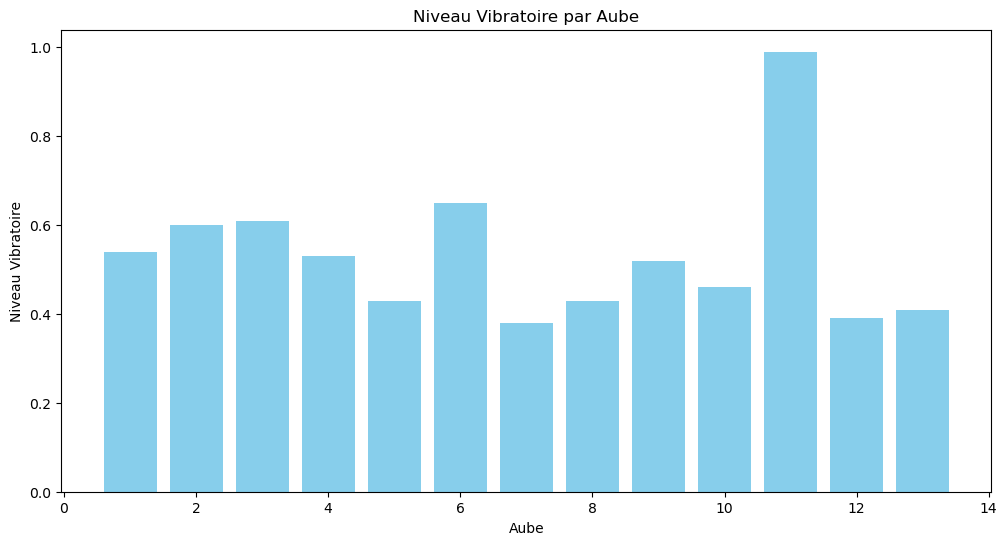

In [73]:
plt.figure(figsize=(12, 6))
plt.bar(vibrations['Essai vibratoire'], vibrations['Unnamed: 1'], color='skyblue')
plt.xlabel('Aube')
plt.ylabel('Niveau Vibratoire')
plt.title('Niveau Vibratoire par Aube')
plt.show()

### 2.2 Analyse par ACP de l'importance des variables géométriques

On dispose d'un grand nombre de variables géométriques (111 variables). On souhaite déterminer quelles sont les variables géométriques importantes en analysant leurs poids dans les composantes principales du jeu de données.

#### 2.2.1 Effectuez une ACP sur le jeu de données géométriques, puis calculez et visualisez la part de variance expliquée par chaque composante principale. Interprétez le résultat. Quelle part de variance est expliquée par les 2 premières CP ?

In [74]:
from sklearn.decomposition import PCA

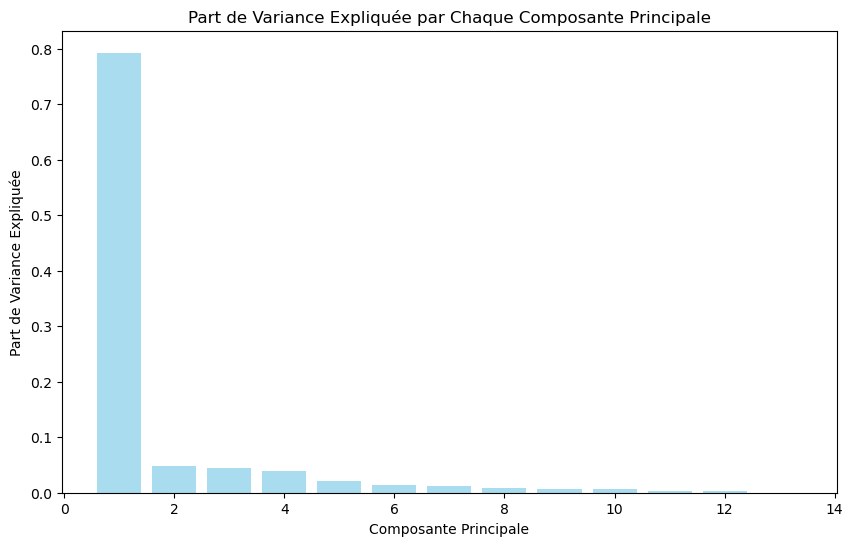

In [75]:
pca=PCA()
geometries_pca = pca.fit_transform(geometries_normalise)
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='skyblue')
plt.ylabel('Part de Variance Expliquée')
plt.xlabel('Composante Principale')
plt.title('Part de Variance Expliquée par Chaque Composante Principale')
plt.show()

In [76]:
variance_expliquee_2_premieres_cp = explained_variance[0] + explained_variance[1]
print(f"Part de variance expliquée par les 2 premières composantes principales: {variance_expliquee_2_premieres_cp:.2%}")

Part de variance expliquée par les 2 premières composantes principales: 84.14%


Une technique très courante pour analyser l'importance des variables est de visualiser leurs poids dans le plan des 2 premières composantes principales.

#### 2.2.2 Visualisez le poids des variables géométriques dans le plan (PC1, PC2)

**Indice 1 :** utilisez pour cela les composantes des vecteurs principaux de la matrice `pca.components_`.

**Indice 2 :** Afin d'obtenir une graphique avec une bonne échelle entre -1 et 1, il est nécessaire d'appliquer aux poids de chaque composante principale un facteur d'échelle égal à $\sqrt{\text{variance expliquée}}$.

Voici le type de graphique, appelé _PCA factor loadings plot_ en anglais, que vous devriez obtenir :

<img src="rc/pca-plot.png" height=500px width=500px />

In [77]:
import numpy as np

scale_factors = np.sqrt(pca.explained_variance_)
loadings = pca.components_[:2].T * scale_factors[:2] 
variance_expliquee = pca.explained_variance_ratio_[:2] * 100


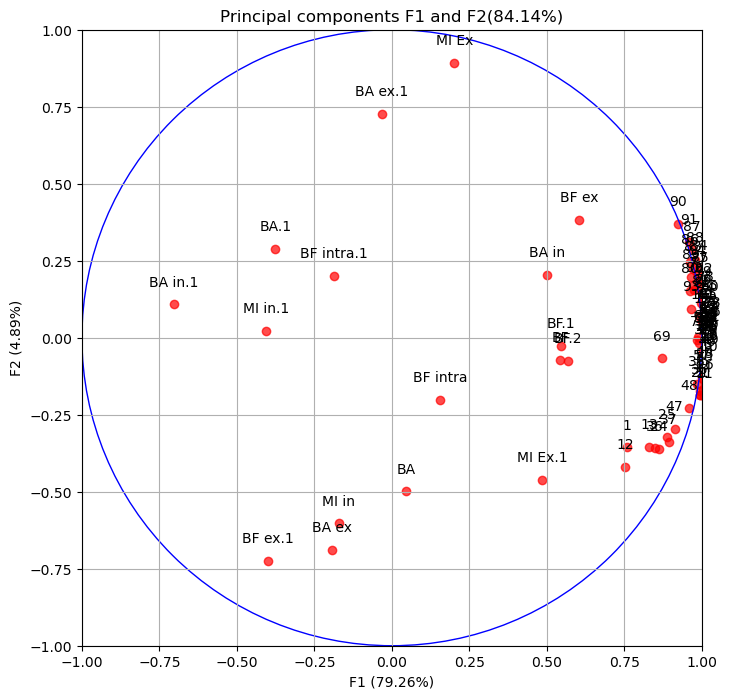

In [78]:
plt.figure(figsize=(8, 8))

plt.scatter(loadings[:, 0], loadings[:, 1], color='red', alpha=0.7)
for i, variable in enumerate(geometries.columns):
    plt.text(loadings[i, 0], loadings[i, 1] + 0.05, variable, ha='center', va='bottom', color='black')



plt.xlabel(f'F1 ({variance_expliquee[0]:.2f}%)')
plt.ylabel(f'F2 ({variance_expliquee[1]:.2f}%)')
plt.title(f'Principal components F1 and F2({variance_expliquee[0]+variance_expliquee[1]:.2f}%)')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.grid()

cercle = plt.Circle((0, 0), 1, color='blue', fill=False, linewidth=1)
plt.gca().add_artist(cercle)


plt.show()


#### 2.2.3 Interprétez le graphique précédent. Quelles sont les variables géométriques les plus importantes ?

Les variables d'épaisseurs (numérotées de 1 à 94) sont toutes situées dans la partie la plus à droite du plan des composantes principales. Elles ont donc un poids très important sur la PC1, beaucoup plus que les autres variables géométriques. Étant donné que la PC1 représente presque 80% de la variance, on peut en conclure que les variables d'épaisseurs sont les plus importantes.

## 3. Identification de l'aube anormale par analyse des corrélations

Suite aux analyses précédentes, on décide de se focaliser sur les variables géométriques correspondant aux épaisseurs de l'aube (variables 1-94). Par ailleurs, les experts mécaniciens nous ont informés que les vibrations étaient corrélées à l'épaisseur de l'aube en différentes points. Par conséquent, nous pouvons décrire les données géométriques en utilisant **seulement la première composante principale** : on se ramène donc à un cas **univarié**, avec une seule variable $\text{PC1}$ (projection sur la première composante principale).

**Objectif :** trouver la permutation circulaire des numérotations d'aubes qui **maximise** la corrélation entre vibrations et épaisseurs des aubes, afin d'identifier l'aube défectueuse.

Voici 3 coefficients de corrélation usuels permettant de mesurer l'association de deux variables (ici, $X =\text{PC1} $ et $Y = \text{vibration}$) :

Coefficient de corrélation | formule | lien wikipédia
---------------------------|----------|---------------
Corrélation de Pearson     | $\rho(X, Y) = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)
Corrélation de Spearman    | $\rho_S(X, Y) = \frac{\text{Cov}(\text{rank}(X), \text{rank}(Y))}{\sigma_{\text{rank}_X} \sigma_{\text{rank}(Y)}}$ | https://fr.wikipedia.org/wiki/Corr%C3%A9lation_de_Spearman
Corrélation de Kendall     | $\tau(X, Y) = \frac{2\sum_{i<j}\text{sign}(x_j-x_i)\text{sign}(y_j-y_i)}{N(N-1)}$ | https://fr.wikipedia.org/wiki/Tau_de_Kendall


### 3.1 Quel(s) coefficient(s) vous semble(nt) adapté(s) pour analyser les corrélations entre nos variables ?

Il vaut mieux utiliser Kendall car nous ne sommes pas dans un cas linéaire (on élimine Pearson) et le coeffecicient de Spearman est plus adapté aux distributions normales.

### 3.2 Calculez les corrélations pour les 12 décalages circulaires possibles entre les données géométriques et les vibrations. Visualisez-les sur un graphique.

**Indice :** on peut facilement obtenir une permuation circulaire d'un jeu de données à l'aide de la fonction `numpy.roll(...)`.

<div style="color: #1111bb; font-size: 16px; background-color: #eeeeff; padding: 20px; border-radius: 15px">
    <p><b>Rappel :</b> On n'utilise que la PC1 des variables géométriques !</p>
</div>

Il est recommandé de calculer les _$p$-values_ associées au coefficient de corrélation choisi. Ces valeurs permettent de déterminer si les corrélations trouvées sont **significatives ou non**. La $p$-value est associée aux deux hypothèses statistiques suivantes :

* $\mathcal{H}_0$ : les variables X et Y sont indépendantes (pas de corrélation)
* $\mathcal{H}_1$ : les variables X et Y sont dépendantes (corrélation)

La $p$-value correspond à la **probabilité de se tromper en rejetant l'hypothèse null $\mathcal{H}_0$**. On fait généralement le choix de rejeter l'hypothèse nulle lorsque $p$-value < 0.05, i.e. moins de 5% de chances de se tromper.

In [79]:
import math
def kendall_tau(x, y):
    """Compute Kendall's tau correlation
    
    Arguments
        xs : float array (n)
            input variable 1
        ys : float array (n)
        input variable 2
        
    Returns
        tau : float in [-1, 1]
            correlation coefficient
        pvalue : float
            p-value
    """
    assert x.size == y.size
    size = x.size
    
    tot = (size * (size-1)) // 2
    s = np.array([np.sign(x[j] - x[i]) * np.sign(y[j] - y[i]) for j in range(size) for i in range(j)])
    tau = np.sum(s) / tot
    
    dis = np.sum(s < 0)  # number of discordant pairs
    # Exact p-value, see Maurice G. Kendall, "Rank Correlation Methods" (4th Edition), Charles Griffin & Co., 1970.
    c = min(dis, tot-dis)
    if size <= 0:
        raise ValueError
    elif c < 0 or 2*c > size*(size-1):
        raise ValueError
    elif size == 1:
        pvalue = 1.0
    elif size == 2:
        pvalue = 1.0
    elif c == 0:
        pvalue = 2.0/math.factorial(size) if size < 171 else 0.0
    elif c == 1:
        pvalue = 2.0/math.factorial(size-1) if (size-1) < 171 else 0.0
    else:
        new = [0.0]*(c+1)
        new[0] = 1.0
        new[1] = 1.0
        for j in range(3,size+1):
            old = new[:]
            for k in range(1,min(j,c+1)):
                new[k] += new[k-1]
            for k in range(j,c+1):
                new[k] += new[k-1] - old[k-j]
        pvalue = 2.0*sum(new)/math.factorial(size) if size < 171 else 0.0
        
    return tau, pvalue

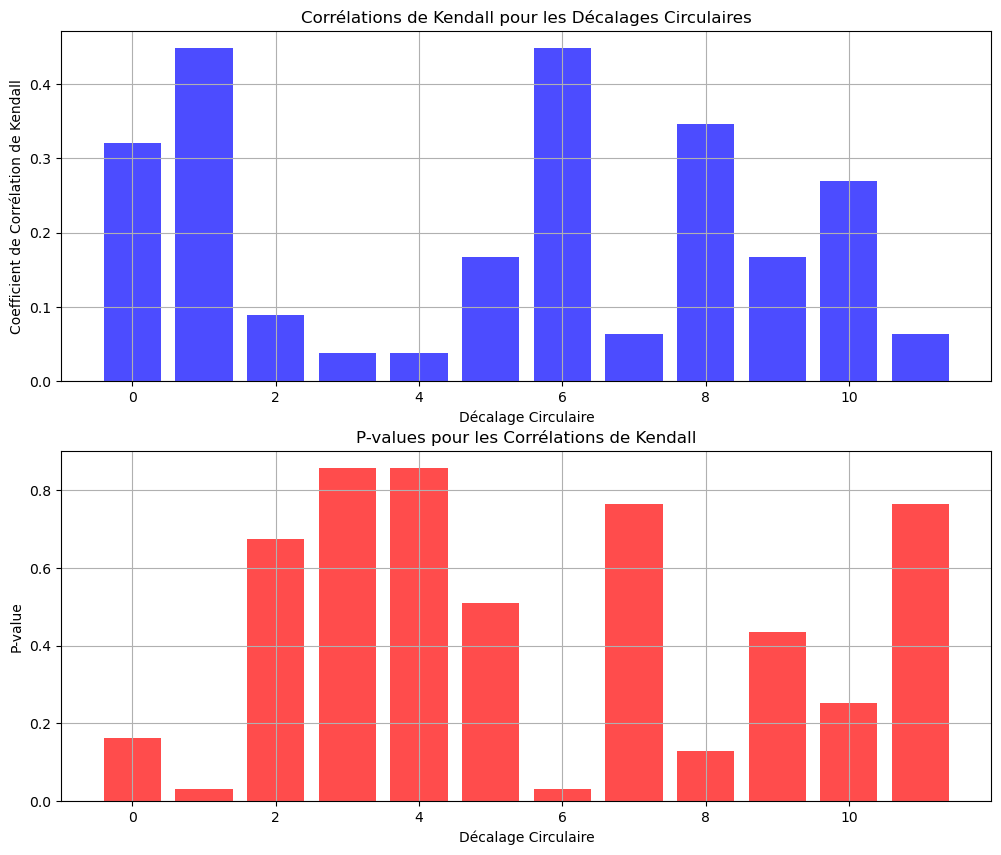

In [80]:
pc1=geometries_pca[:, 0]
vibrations1= vibrations['Unnamed: 1']
kendall_corr=[]
pvalues=[]
for n in range(12):
    pc1_ken = np.roll(pc1,n)
    kendall_co,pvalue=kendall_tau(pc1_ken,vibrations1)
    kendall_corr.append(np.abs(kendall_co))
    pvalues.append(pvalue)



fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


ax1.bar(range(12), kendall_corr, color="blue", alpha=0.7)
ax1.set_xlabel("Décalage Circulaire")
ax1.set_ylabel("Coefficient de Corrélation de Kendall")
ax1.set_title("Corrélations de Kendall pour les Décalages Circulaires")
ax1.grid()

ax2.bar(range(12), pvalues, color="red", alpha=0.7)
ax2.set_xlabel("Décalage Circulaire")
ax2.set_ylabel("P-value")
ax2.set_title("P-values pour les Corrélations de Kendall")
ax2.grid()



### 3.3 Quel est le décalage circulaire qui maximise la corrélation ? (il peut éventuellement en y avoir plusieurs) Peut-on en déduire l'aube anormale ?

Ce sont les décalages 1 et 6 qui maximise la corrélation.

### 3.4 L'analyse de la PC1 ne s'est pas révélée suffisante, une analyse plus fine est nécessaire. Calculez, pour chaque décalage circulaire de la numérotation des aubes, les corrélations entre toutes les variables d'épaisseur (94 variables) et le niveau vibratoire. Concluez sur l'identité de l'aube défaillante, ainsi que sur la zone précise du défaut.

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

pc1 = geometries.iloc[:, :94]

correlations_par_decalage = {decalage: [] for decalage in range(12)}
p_values_par_decalage = {decalage: [] for decalage in range(12)}  # Stocker aussi les p-values

for decalage in range(12):
    pc1_shifted = pc1.apply(lambda x: np.roll(x, decalage), axis=0)
    
    correlations = []
    p_values = []
    for col in pc1_shifted.columns:
        kendall_corr, pvalue = kendall_tau(pc1_shifted[col].values, vibrations1)
        correlations.append(kendall_corr)
        p_values.append(pvalue)
    
    correlations_par_decalage[decalage] = correlations
    p_values_par_decalage[decalage] = p_values



##### Pour une analyse plus simple, utilisons des dataframes.

In [82]:
correlations_df = pd.DataFrame(correlations_par_decalage, index=pc1.columns)
p_values_df = pd.DataFrame(p_values_par_decalage, index=pc1.columns)

Affichons, les résultats pour les 94 variables:

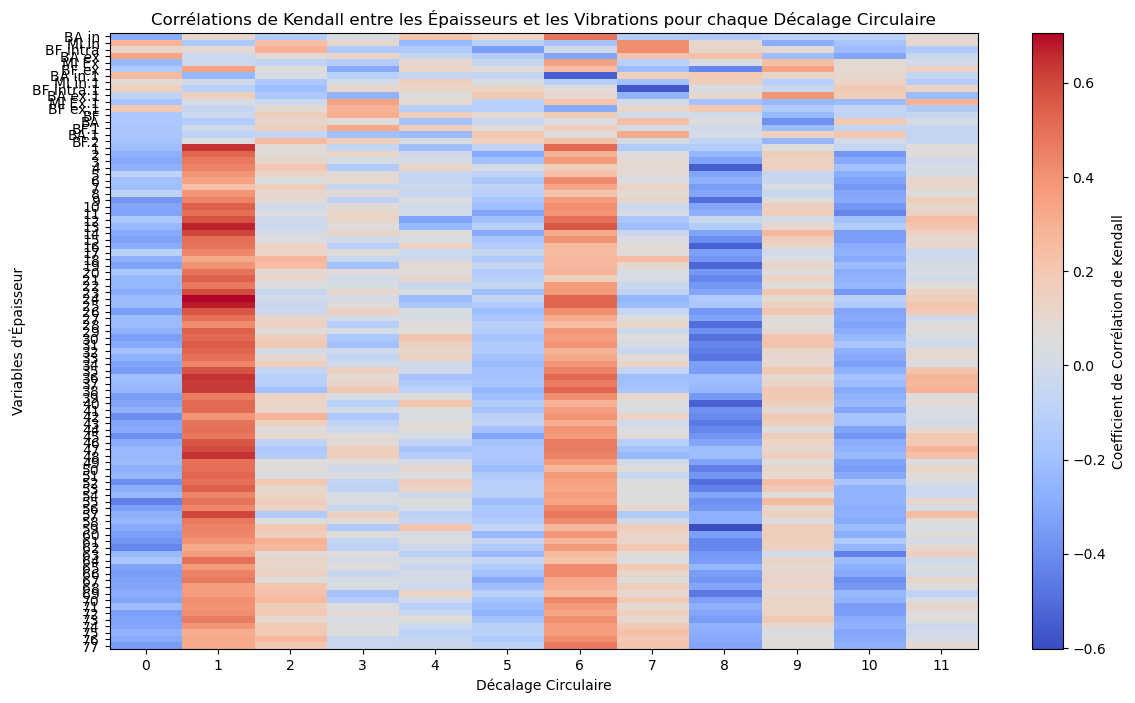

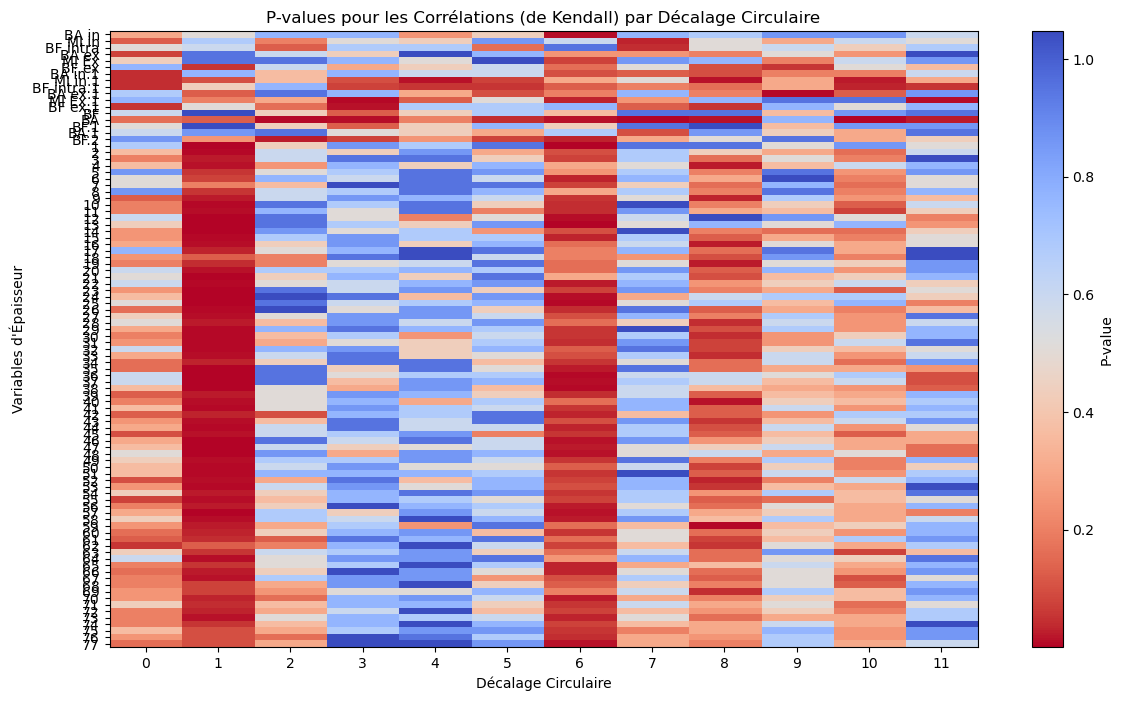

In [83]:
plt.figure(figsize=(14, 8))
plt.imshow(correlations_df, cmap='coolwarm', aspect='auto', interpolation='nearest')
plt.colorbar(label="Coefficient de Corrélation de Kendall")
plt.xlabel("Décalage Circulaire")
plt.ylabel("Variables d'Épaisseur")
plt.title("Corrélations de Kendall entre les Épaisseurs et les Vibrations pour chaque Décalage Circulaire")
plt.xticks(range(12), labels=range(12))
plt.yticks(range(94), labels=pc1.columns)
plt.show()


plt.figure(figsize=(14, 8))
plt.imshow(p_values_df, cmap='coolwarm_r', aspect='auto', interpolation='nearest')
plt.colorbar(label="P-value")
plt.xlabel("Décalage Circulaire")
plt.ylabel("Variables d'Épaisseur")
plt.title("P-values pour les Corrélations (de Kendall) par Décalage Circulaire")
plt.xticks(range(12), labels=range(12))
plt.yticks(range(94), labels=pc1.columns)
plt.show()

On suppose désormais que c'est le décalge numéro 1 qui possède un soucis (soit l'aube 10). Vérifions cela par un bar plot et affichons le clairement.

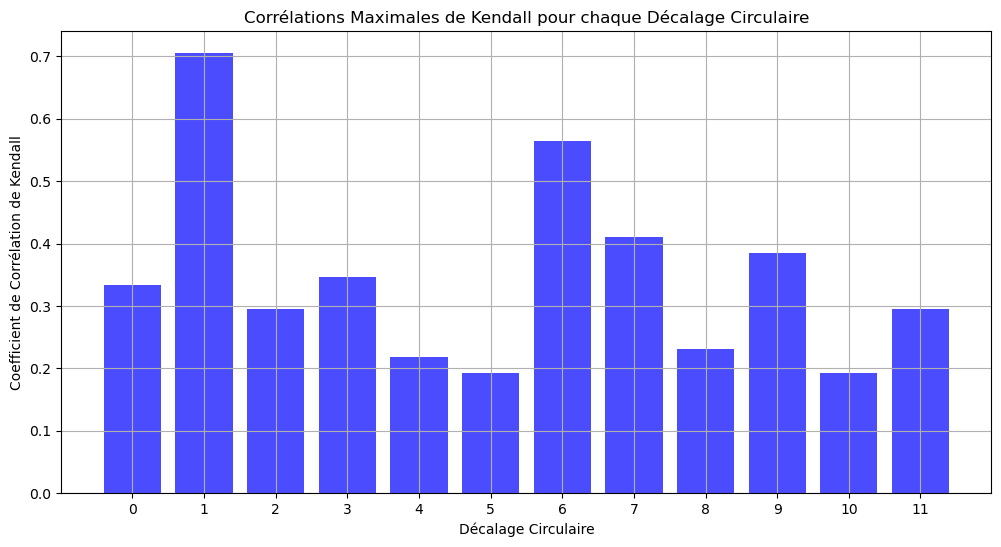

In [84]:
max_correlations = correlations_df.max()

plt.figure(figsize=(12, 6))
plt.bar(range(12), max_correlations, color="blue", alpha=0.7)
plt.xlabel("Décalage Circulaire")
plt.ylabel("Coefficient de Corrélation de Kendall")
plt.title("Corrélations Maximales de Kendall pour chaque Décalage Circulaire")
plt.xticks(range(12))
plt.grid()
plt.show()

In [85]:
decalage_aube = {
    0: 11, 1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1, 11: 12, 12: 13
}

max_correlation_par_variable = correlations_df.max(axis=1)
meilleur_decalage_par_variable = correlations_df.idxmax(axis=1)

corr_maximale = max_correlation_par_variable.max()
variable_corr_maximale = max_correlation_par_variable.idxmax()
decalage_optimal = meilleur_decalage_par_variable[variable_corr_maximale]

aube_defaillante = decalage_aube[decalage_optimal]

print(f"\nAube défaillante : {aube_defaillante}")
print(f"Zone précise du défaut (variable d'épaisseur) : {variable_corr_maximale}")
print(f"Valeur de corrélation maximale : {corr_maximale:.2f}")



Aube défaillante : 10
Zone précise du défaut (variable d'épaisseur) : 24
Valeur de corrélation maximale : 0.71


### Donc c'est l'aube 10 qui présente un problème. La zone précise est la variable 24, bien qu'il serait peut être plus pertinent de mettre un seuil ( il est possible que d'autres variables contiennent un défaut ).

In [86]:
decalage_aube = {
    0: 11, 1: 10, 2: 9, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1, 11: 12, 12: 13
}

seuil_correlation = 0.60
variables_problematique = max_correlation_par_variable[max_correlation_par_variable >= seuil_correlation]
decalages_problematique = meilleur_decalage_par_variable[variables_problematique.index]

print(f"\nAubes défaillantes possibles et variables d'épaisseur associées :")
for variable, correlation in variables_problematique.items():
    decalage_optimal = decalages_problematique[variable]
    aube_defaillante = decalage_aube[decalage_optimal] 
    print(f"Variable d'épaisseur : {variable} - Corrélation : {correlation:.2f} - Aube : {aube_defaillante}")



Aubes défaillantes possibles et variables d'épaisseur associées :
Variable d'épaisseur : 1 - Corrélation : 0.64 - Aube : 10
Variable d'épaisseur : 13 - Corrélation : 0.67 - Aube : 10
Variable d'épaisseur : 14 - Corrélation : 0.60 - Aube : 10
Variable d'épaisseur : 24 - Corrélation : 0.71 - Aube : 10
Variable d'épaisseur : 25 - Corrélation : 0.68 - Aube : 10
Variable d'épaisseur : 36 - Corrélation : 0.64 - Aube : 10
Variable d'épaisseur : 37 - Corrélation : 0.63 - Aube : 10
Variable d'épaisseur : 38 - Corrélation : 0.63 - Aube : 10
Variable d'épaisseur : 48 - Corrélation : 0.64 - Aube : 10
Variable d'épaisseur : 57 - Corrélation : 0.60 - Aube : 10
